# Udacity Data Wrangling Project

### Importing Libraries and Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import requests


import twitter_credentials
%matplotlib inline

## Gather Part I

###  Using Get Request

In [2]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if response.status_code == 200:
    print('Success!')
elif response.status_code == 404:
    print('Not Found.')

Success!


### Importing data manually with Pandas

In [3]:
images = pd.read_csv('image_predictions.tsv', sep = '\t', encoding = 'utf-8')

In [4]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv')

## Assessment Part I 
### Visual Assessment

In [5]:
df_1.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,8.924210e+17,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,8.921770e+17,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,8.918150e+17,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,8.916900e+17,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,8.913280e+17,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,8.910880e+17,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,8.909720e+17,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,8.907290e+17,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,8.906090e+17,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,8.902400e+17,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [6]:
images.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


## Assessment Part I 
### Programatic Assessment

In [7]:
images.duplicated().any()

False

In [8]:
df_1.query('tweet_id == "NaN"').count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [9]:
df_1.duplicated().any()

False

In [10]:
df_1[df_1.tweet_id.duplicated()].count()

tweet_id                      7
in_reply_to_status_id         1
in_reply_to_user_id           1
timestamp                     7
source                        7
text                          7
retweeted_status_id           3
retweeted_status_user_id      3
retweeted_status_timestamp    3
expanded_urls                 6
rating_numerator              7
rating_denominator            7
name                          7
doggo                         7
floofer                       7
pupper                        7
puppo                         7
dtype: int64

In [11]:
df_1.tweet_id.duplicated().any()  

True

In [12]:
df_1.query('tweet_id == 0').count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [13]:
df_1.expanded_urls.isnull().any()

True

In [14]:
df_1.tweet_id.head()

0    8.924210e+17
1    8.921770e+17
2    8.918150e+17
3    8.916900e+17
4    8.913280e+17
Name: tweet_id, dtype: float64

In [15]:
with pd.option_context('float_format', '{:.0f}'.format):  
    print(df_1.tweet_id.head())

0   892421000000000000
1   892177000000000000
2   891815000000000000
3   891690000000000000
4   891328000000000000
Name: tweet_id, dtype: float64


In [16]:
df_1.duplicated().any()

False

## Cleaning I 
### Summary of Assessments

#### Creating a Cute Name Column to Tidy Data

In [17]:
df_1.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                   'retweeted_status_user_id','retweeted_status_timestamp',
                   ], inplace=True)

In [18]:
df_1['cute_name'] = df_1['doggo'].str.cat(df_1['pupper']
                                         .replace('None','')).str.cat(df_1['floofer']
                                                                      .replace('None','')).str.cat(df_1['pupper']
                                                                                                   .replace('None','')).str.cat(df_1['puppo']
                                                                                                                                .replace('None',''))

In [19]:
df_1['cute_name'] = df_1.cute_name.replace('Nonefloofer','floofer')
df_1['cute_name'] = df_1.cute_name.replace('Nonepupper','pupper')
df_1['cute_name'] = df_1.cute_name.replace('Nonepuppo','puppo')
df_1['cute_name'] = df_1.cute_name.replace('None','Other')
df_1.drop(columns=['doggo', 'floofer','pupper', 'puppo'],inplace=True)

In [20]:
df_1.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'cute_name'],
      dtype='object')

#### Extracting Tweet Id's from URLs

In [21]:
df_1['expanded_urls'] = df_1.expanded_urls.fillna(value='https://www.twitter.com')
urls = df_1.expanded_urls
urls = list(urls)

In [22]:
status= []
for i in range(len(urls)): 
    t= urls[i]
    if bool(re.search(r'\d', t)) == True:
        twt = re.findall(r'\d+', t)[0]
        status.append(twt)
    else:
        status.append('NaN')
status[:5]

['892420643555336193',
 '892177421306343426',
 '891815181378084864',
 '891689557279858688',
 '891327558926688256']

In [23]:
df_1['tweet_id'] = status
df_1.tweet_id.isnull().any()

False

In [24]:
df_1['tweet_id'] = df_1.tweet_id.replace('NaN', 0)

In [25]:
df_1 = df_1.astype({'tweet_id':'int64'})

In [26]:
df_1.duplicated().any()

False

In [27]:
df_1 = df_1.drop_duplicates(keep='first')

## Gather Part II

In [28]:
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
            
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)


In [29]:
#df_2 = pd.DataFrame(columns=['tweet_id','retweet count','favorite_count'])

#with open('tweet_json.txt') as i:
#    for line in i:
#        stat = json.loads(line)
#        tweet_id = stat['id_str']
#        retweet_count = stat['retweet_count']
#        favorite_count = stat['favorite_count']
#        df_2 = df_2.append(pd.DataFrame([[tweet_id,retweet_count,
#                                         favorite_count]], 
#                                       columns=['tweet_id',
#                                        'retweet_count', 'favorite_count']))
#df_2 = df_2.reset_index(drop=True)
#df_2.head()
        

In [30]:
#df_2.to_csv (r'C:\Users\tssan\Desktop\Udacity Projects\4wrangle\WeRateDogs.csv',
#                          index = None, header=True, sep='\t', encoding='utf-8')

In [31]:
df_2 = pd.read_csv('WeRateDogs.csv', sep='\t',encoding='utf-8')

## Assessment Part II
### Visual Assessment

In [32]:
df_2.head(20)

,favorite_count,retweet count,retweet_count,tweet_id
0,37135,NaN,7937.0,892420643555336193
1,31939,NaN,5900.0,892177421306343426
2,24054,NaN,3899.0,891815181378084864
3,40456,NaN,8095.0,891689557279858688
4,38672,NaN,8778.0,891327558926688256
5,19442,NaN,2917.0,891087950875897856
6,11340,NaN,1937.0,890971913173991426
7,62632,NaN,17701.0,890729181411237888
8,26740,NaN,4020.0,890609185150312448
9,30632,NaN,6903.0,890240255349198849


## Assessment Part II
### Programatic Assessment

In [33]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 4 columns):
favorite_count    2166 non-null int64
retweet count     0 non-null float64
retweet_count     2166 non-null float64
tweet_id          2166 non-null int64
dtypes: float64(2), int64(2)
memory usage: 67.8 KB


Ask Questions about the data
Anything out of place? 
Too large? Too small? 


In [34]:
df_2.duplicated().any()

True

In [35]:
df_1.duplicated().any()

False

In [36]:
images.duplicated().any()

False

In [37]:
len(df_1), len(df_2)

(2356, 2166)

In [38]:
df_1.query('rating_denominator > 10')['rating_denominator']

342      15
433      70
784      11
902     150
1068     11
1120    170
1165     20
1202     50
1228     90
1254     80
1274     50
1351     50
1433     40
1598     20
1634    130
1635    110
1662     11
1663     16
1779    120
1843     80
Name: rating_denominator, dtype: int64

In [39]:
df_1.query('rating_denominator < 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,cute_name
313,0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,https://www.twitter.com,960,0,None,Other
516,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,Other
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,an,Other


In [40]:
df_1.text[313],df_1.text[516],df_1.text[2335]

("@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
 'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \r\nKeep Sam smiling by clicking and sharing this link:\r\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv')

In [41]:
df_1.groupby(['rating_numerator']).count()

,tweet_id,timestamp,source,text,expanded_urls,rating_denominator,name,cute_name
rating_numerator,,,,,,,,
0,2,2,2,2,2,2,2,2
1,9,9,9,9,9,9,9,9
2,9,9,9,9,9,9,9,9
3,19,19,19,19,19,19,19,19
4,17,17,17,17,17,17,17,17
5,37,37,37,37,37,37,37,37
6,32,32,32,32,32,32,32,32
7,55,55,55,55,55,55,55,55
8,102,102,102,102,102,102,102,102


In [42]:
df_1[df_1['rating_numerator'] == 75]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,cute_name
340,786709082849828864,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,Other
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,Other


In [43]:
df_1.text[340], df_1.text[695]

("RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS")

## Cleaning Part II
### Summary of Assessments
Fixing Errors in Numerators & Denominators

In [44]:
df_1.loc[313, 'rating_denominator']= 10
df_1.loc[313, 'rating_numerator']= 13
print(f"This dog's rating is {df_1.loc[313,'rating_numerator']}/{df_1.loc[313,'rating_denominator']}")

This dog's rating is 13/10


In [45]:
df_1.loc[2335, 'rating_denominator']= 10
df_1.loc[2335, 'rating_numerator']= 9
print(f"This dog's rating is {df_1.loc[2335,'rating_numerator']}/{df_1.loc[2335,'rating_denominator']}")

This dog's rating is 9/10


In [46]:
df_1.loc[516, 'rating_numerator']= np.median(df_1.rating_numerator)
df_1.loc[516, 'rating_denominator']= np.median(df_1.rating_denominator)
print(f"Since Sam was never given a rating, I gave him the median rating which is {df_1.loc[516,'rating_numerator']}/{df_1.loc[516,'rating_denominator']}")

Since Sam was never given a rating, I gave him the median rating which is 11.0/10.0


In [47]:
df_2.drop(columns='retweet count', inplace= True)

In [48]:
df_2 = df_2.drop_duplicates(keep='first')

In [49]:
images = images.drop_duplicates(keep='first')

In [50]:
df = df_1.merge(df_2, on='tweet_id', how='inner')

In [51]:
df = df.merge(images, on='tweet_id', how='inner')

In [52]:
df.tweet_id.duplicated().any()

True

In [53]:
df = df.drop_duplicates(subset=['tweet_id'],keep='first')

In [54]:
df.duplicated().any()

False

In [55]:
df = df.reset_index(drop=True)
# Get rid of <source, img_num>
df.drop(columns=['source','img_num'],inplace=True)

#### Normalizing Denominators to a Standard of 10  

In [56]:
norm_numerator= []
norm_denominator= []
for i, row in df.iterrows():
    norm = 10 / row['rating_denominator']
    num = row['rating_numerator'] = row['rating_numerator']* norm
    norm_numerator.append(num)
    den = row['rating_denominator'] = row['rating_denominator']* norm
    norm_denominator.append(den)
    

In [57]:
df['rating_numerator'] = norm_numerator
df['rating_denominator'] = norm_denominator

In [58]:
df.query('rating_denominator !=10')['rating_denominator'].any()

False

#### Correcting Ratings Containing Decimal Places

In [59]:
# Using Regular Expression to loop through each text and pull out any digits with decimal places
for i, row in df.iterrows():
    in_str= row['text']
    split = re.split(r'/' , in_str)[0]
    if bool(re.search(r'\d+\.\d+$', split)) == True:
        after = re.findall(r'\d+\.\d+', split)[0]
        before = df.loc[i, 'rating_numerator']
        df.loc[i, 'rating_numerator'] = after
        print(f"The numerator in row {i} used to be {before} and now is {after}.")
    else:
        pass

The numerator in row 40 used to be 5.0 and now is 13.5.
The numerator in row 262 used to be 75.0 and now is 9.75.
The numerator in row 585 used to be 27.0 and now is 11.27.
The numerator in row 1380 used to be 26.0 and now is 11.26.


In [60]:
df['rating_numerator'] = df['rating_numerator'].astype('float64')
df['rating_denominator'] = df['rating_denominator'].astype('float64')

In [61]:
#No longer need the denominator columns, and the rating_numerator column
#can just become rating (on a standardized scale of 10)
df.drop(columns=['rating_denominator'])
df.rename(columns={"rating_numerator": "rating"},inplace=True)

In [62]:
df.to_csv (r'C:\Users\tssan\Desktop\Udacity Projects\4wrangle\WeRateDogs_CleanedData.csv',
                        index = None, header=True, sep='\t', encoding='utf-8')

In [63]:
df_cln = pd.read_csv('WeRateDogs_CleanedData.csv', sep='\t',encoding='utf-8')

## Finding a Winner

In [64]:
df_cln.groupby(['rating']).count()

,tweet_id,timestamp,text,expanded_urls,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating,,,,,,,,,,,,,,,,,,,
0.000000,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1.000000,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2.000000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
3.000000,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
4.000000,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5.000000,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6.000000,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6.363636,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7.000000,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [65]:
df_cln[df_cln['rating'] == 420]

,tweet_id,timestamp,text,expanded_urls,rating,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1712,670842764863651840,2015-11-29 05:52:33 +0000,After so many requests... here you go.\r\n\r\n...,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,None,Other,24351,8574.0,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False


In [66]:
df_cln.text[1712]

'After so many requests... here you go.\r\n\r\nGood dogg. 420/10 https://t.co/yfAAo1gdeY'

In [67]:
print(df_cln.jpg_url[1712])

https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg


### At second place Snoop Dogg comes in at very impressive 420 out of 10
<img src="second.jpg"/>

In [68]:
df_cln[df_cln['rating'] == 1776]

,tweet_id,timestamp,text,expanded_urls,rating,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
757,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,Other,5253,2528.0,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False


In [69]:
df_cln.text[757]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [70]:
print(df_cln.jpg_url[757])

https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg


### Congratulation to the winner coming in at 1776 out of 10, no easy feat!
<img src="winner.jpg"/>

## Distribution of Dog Ratings by Dog Types

These data points were accurately gathered, but are global outliers that greatly increase the standard deviation of the ratings.  
Because of this, I decided to remove the two remaining outliers, and only evaluated the observations of 14 or less.

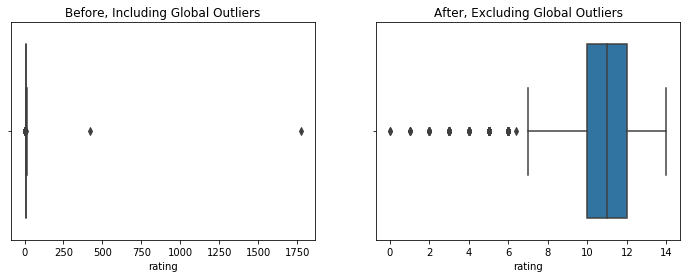

In [71]:
df_before= df_cln.copy()
df_after = df_cln[df_cln['rating'] < 15]

#df_before= plots of the distribution of the data before and after removing the two outliers
f, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_before,x= 'rating',orient='w', ax=axes[0])
axes[0].set_title('Before, Including Global Outliers')


sns.boxplot(data=df_after, x= 'rating',orient='w', ax=axes[1])
axes[1].set_title('After, Excluding Global Outliers');

In [72]:
df_rate = df_after.copy()

In [73]:
# Rounding Ratings to get a discrete scale
for i, row in df_rate.iterrows():
    before = df_rate.loc[i, 'rating']
    after = round(df_rate.rating[i], 0)
    df_rate.loc[i, 'rating'] = after
    if bool(before == after) == False :
        print(f"The rating in row {i} used to be {before} and now is {after}.")
    else:
        pass

The rating in row 40 used to be 13.5 and now is 14.0.
The rating in row 262 used to be 9.75 and now is 10.0.
The rating in row 585 used to be 11.27 and now is 11.0.
The rating in row 602 used to be 8.181818181818182 and now is 8.0.
The rating in row 1336 used to be 6.363636363636362 and now is 6.0.
The rating in row 1380 used to be 11.26 and now is 11.0.


In [74]:
df_rate['p1'].value_counts()

golden_retriever      138
Labrador_retriever     92
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
cheeseburger            1
standard_schnauzer      1
wooden_spoon            1
tailed_frog             1
cuirass                 1
Name: p1, Length: 372, dtype: int64

In [75]:
dog_types = df_rate['p1'].value_counts().keys()
dog_types = list(dog_types)

In [76]:
dog_types = dog_types[:9]

In [77]:
for d in dog_types:
    df_other = df_rate[(df_rate.p1 != d)]

df_other = df_other.rating.value_counts().sort_index()
df_other = df_other.rename_axis('rating').to_frame('other')

for d in dog_types:
    df_add = df_rate[df_rate['p1'] == d ]
    df_add = df_add.rating.value_counts().sort_index()
    df_add = df_add.rename_axis('rating').to_frame(d)
    df_other = df_other.merge(df_add, on='rating',how='left').fillna(0)
    

df_other.loc[:,'Total'] = df_other.sum(axis=1)
df_other.index = df_other.index.map(str)
df_other.columns = [x.lower() for x in df_other.columns]
df_all = df_other.copy()
df_all

,other,golden_retriever,labrador_retriever,pembroke,chihuahua,pug,chow,samoyed,pomeranian,toy_poodle,total
rating,,,,,,,,,,,
0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3.0,19,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,21.0
4.0,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
5.0,32,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,34.0
6.0,33,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,35.0
7.0,51,0.0,1.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,60.0
8.0,96,3.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,108.0


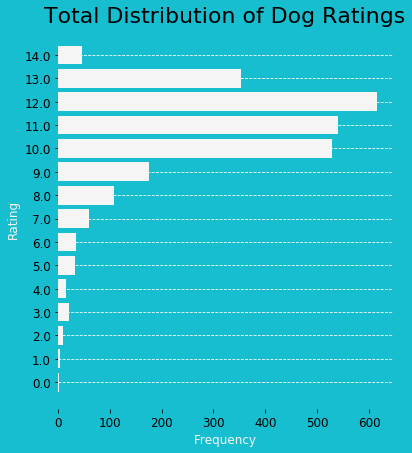

In [78]:
b='Black'
r = df_all.index
t = df_all.total
c= sns.color_palette()[9]
f_sz=12
w='whitesmoke'
fig = plt.figure(figsize=(6,7), facecolor=c)

            
ax = plt.subplot(1, 1, 1)
plt.barh(range(len(r)),t, color=w)
plt.yticks(range(len(r)),r,fontsize=12, color=b)
plt.ylabel('Rating',color=w,fontsize=f_sz)
plt.xticks(color=b,fontsize=f_sz)
plt.xlabel('Frequency',color=w,fontsize=f_sz)
plt.title('Total Distribution of Dog Ratings',color='Black',fontsize=22)

ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='dashed')
plt.box(False)
plt.show()

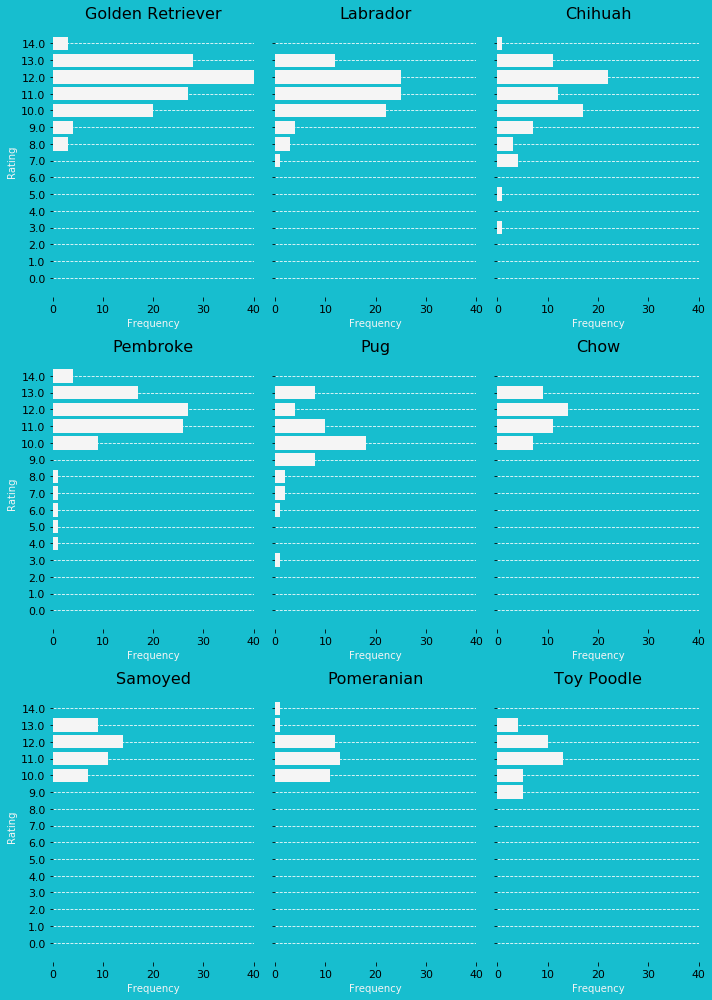

In [79]:
from mpl_toolkits.axes_grid1 import Grid
i = df_all.index
t = df_all.total
r = df_all.index
ch = df_all.chihuahua
g = df_all.golden_retriever
l = df_all.labrador_retriever
p = df_all.pembroke
pu = df_all.pug
ow = df_all.chow
s = df_all.samoyed
pm = df_all.pomeranian
tp = df_all.toy_poodle
c= sns.color_palette()[9]
w='whitesmoke'
b='Black'
f_sz=16
lim = [0,40]
fig = plt.figure(figsize=(10,14), facecolor=c)
grid = Grid(fig, rect=111, nrows_ncols=(2,2),
            axes_pad=0.25, label_mode='L')



ax1= plt.subplot(3, 3, 1)
plt.barh(range(len(r)),g, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b,fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Golden Retriever',fontsize=f_sz,color=b)
plt.xlim(lim)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='white', linestyle='dashed')

ax2= plt.subplot(3, 3, 2)
plt.barh(range(len(r)),l, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Labrador',fontsize=f_sz,color=b)
plt.xlim(lim)
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='white', linestyle='dashed')

ax3 = plt.subplot(3, 3, 3)
plt.barh(range(len(r)),ch, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chihuah',fontsize=f_sz,color=b)
plt.xlim(lim)
ax3.set_axisbelow(True)
ax3.yaxis.grid(color='white', linestyle='dashed')

ax4 = plt.subplot(3, 3, 4)
plt.barh(range(len(r)),p, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Pembroke',fontsize=f_sz,color=b)
plt.xlim(lim)
ax4.set_axisbelow(True)
ax4.yaxis.grid(color='white', linestyle='dashed')

ax5 = plt.subplot(3, 3, 5)
plt.barh(range(len(r)),pu, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pug', fontsize=f_sz, color=b)
plt.xlim(lim)
ax5.set_axisbelow(True)
ax5.yaxis.grid(color='white', linestyle='dashed')

ax6 = plt.subplot(3, 3, 6)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chow', fontsize=f_sz, color=b)
plt.xlim(lim)
ax6.set_axisbelow(True)
ax6.yaxis.grid(color='white', linestyle='dashed')

ax7 = plt.subplot(3, 3, 7)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.setp(ax7.get_yticklabels(), visible=True)
plt.box(False)
plt.title('Samoyed', fontsize=f_sz, color=b)
plt.xlim(lim)
ax7.set_axisbelow(True)
ax7.yaxis.grid(color='white', linestyle='dashed')

ax8 = plt.subplot(3, 3, 8)
plt.barh(range(len(r)),pm, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax8.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pomeranian', fontsize=f_sz, color=b)
plt.xlim(lim)
ax8.set_axisbelow(True)
ax8.yaxis.grid(color='white', linestyle='dashed')

ax9 = plt.subplot(3, 3, 9)
plt.barh(range(len(r)),tp, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Toy Poodle', fontsize=f_sz, color=b)
plt.xlim(lim)
ax9.set_axisbelow(True)
ax9.yaxis.grid(color='white', linestyle='dashed')

plt.tight_layout()
plt.show()

## Time Series of WeRateDogs Tweets

In [80]:
df_time = df_cln.copy()

In [81]:
df_time['timestamp'].min(), df_time['timestamp'].max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

In [82]:
time = df_time['timestamp']

In [83]:
time = list(time)

In [84]:
times = []
for i in range(len(time)): 
    t= time[i]
    stamp = t.rpartition(':')[0]
    times.append(stamp)

In [85]:
times[:5]

['2017-08-01 16:23',
 '2017-08-01 00:17',
 '2017-07-31 00:18',
 '2017-07-30 15:58',
 '2017-07-29 16:00']

In [86]:
df_time['timestamp'] = times

In [87]:
df_time['timestamp'] = pd.to_datetime(df_time['timestamp'])

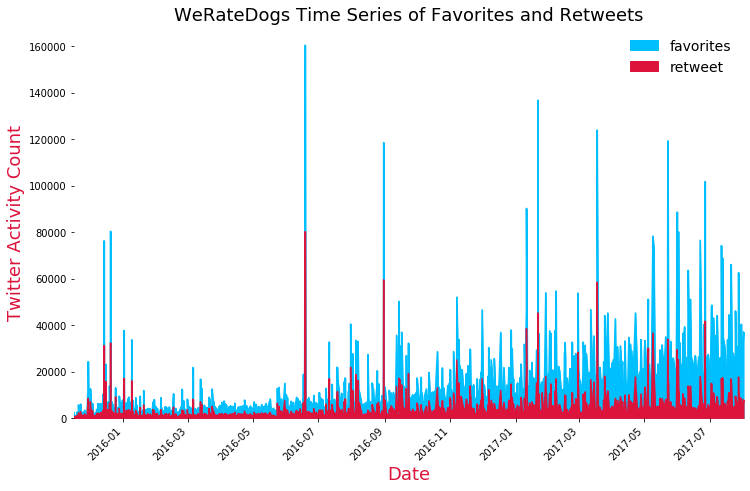

In [88]:
# TimeSeries of Twitter Activity 

#Favorite and Retweet series
time_faves = pd.Series(data=df_time['favorite_count'].values, index=df_time['timestamp'])
time_retweets = pd.Series(data=df_time['retweet_count'].values, index=df_time['timestamp'])

#Plotting both series to the same axis
size= (12,8)

time_faves.plot(kind='area',figsize=size, label='favorites',
                color='deepskyblue',legend=True)
time_retweets.plot(kind='area',figsize=size, label='retweet',
                   color='crimson',legend=True)

#Labels and preferences for the visualization

plt.title('WeRateDogs Time Series of Favorites and Retweets',fontsize=18)
plt.xlabel('Date',fontsize=18,color='crimson') 
plt.ylabel('Twitter Activity Count',fontsize=18, color='crimson')
plt.xticks(rotation=45)
plt.legend(fontsize=14,frameon=False)

plt.box(False)
plt.show();